In [ ]:
# скачиваем файлы
!wget --no-check-certificate 'https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0' -O train_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0' -O train_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/7thqkuxnwsa7njj/test_transaction.csv?dl=0' -O test_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/b40nvbb9e2usd5w/test_identity.csv?dl=0' -O test_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/arkyoz0bel8z4d2/sample_submission.csv?dl=0' -O sample_submission.csv

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

sns.set()

%matplotlib inline

In [ ]:
def reduce_mem_usage(df):
    NAlist = [] # Keeps track of columns that have missing values filled in.
    for col in tqdm(df.columns):
        if df[col].dtype != object:  # Exclude strings

            # make variables for Int, max and min
            IsInt = False
            col_max_value = df[col].max()
            col_min_value = df[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all():
                NAlist.append(col)
                df[col].fillna(col_min_value - 1, inplace=True)

            # test if column can be converted to an integer
            col_as_int = df[col].fillna(0).astype(np.int64)
            diff = (df[col] - col_as_int)
            diff = diff.sum()
            if np.abs(diff) < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if col_min_value >= 0:
                    if col_max_value < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif col_max_value < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif col_max_value < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if col_min_value > np.iinfo(np.int8).min and col_max_value < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif col_min_value > np.iinfo(np.int16).min and col_max_value < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif col_min_value > np.iinfo(np.int32).min and col_max_value < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif col_min_value > np.iinfo(np.int64).min and col_max_value < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)

    return df, NAlist

In [ ]:
INPUT_DIR = '.'

train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'train_identity.csv'))
test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'test_transaction.csv'))
test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'test_identity.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
del train_transaction, train_identity
df_train, df_train_NAlist = reduce_mem_usage(df_train)

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')
del test_transaction, test_identity
df_test, df_test_NAlist = reduce_mem_usage(df_test)

100%|██████████| 433/433 [00:26<00:00, 16.46it/s]


В данных есть пропуски:

In [ ]:
print('Missing data in train: {:.5f}%'.format(df_train.isnull().sum().sum() / (df_train.shape[0] * df_train.shape[1]) * 100))
print('Missing data in test: {:.5f}%'.format(df_test.isnull().sum().sum() / (df_test.shape[0] * df_test.shape[1]) * 100))

Missing data in train: 4.47002%
Missing data in test: 4.33051%


Заполним пропуски в столбцах, где значения выражаются числами - `-1`, а где строками - `'unseen_category'`.

In [ ]:
for col in df_train.columns.drop('isFraud'):
    if df_train[col].dtype == 'O':
        df_train[col] = df_train[col].fillna('unseen_category')
        df_test[col] = df_test[col].fillna('unseen_category')
    else:
        df_train[col] = df_train[col].fillna(-1)
        df_test[col] = df_test[col].fillna(-1)

print('Missing data in train: {:.5f}%'.format(df_train.isnull().sum().sum() / (df_train.shape[0] * df_train.shape[1]) * 100))
print('Missing data in test: {:.5f}%'.format(df_test.isnull().sum().sum() / (df_test.shape[0] * df_test.shape[1]) * 100))

Missing data in train: 0.00000%
Missing data in test: 0.00000%


In [ ]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(80), int16(7), int8(9), object(31), uint16(40), uint32(3), uint8(264)
memory usage: 380.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float32(78), int16(6), int8(9), object(31), uint16(57), uint32(3), uint8(249)
memory usage: 159.0+ MB


(None, None)

Закодируем категориальные признаки с помощью [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) и сконвертируем их в [`category`](https://pandas.pydata.org/pandas-docs/version/0.23.4/categorical.html).

In [ ]:
for col in tqdm(df_train.columns.drop('isFraud')):
    if df_train[col].dtype == 'O':
        le = LabelEncoder()
        le.fit(list(df_train[col]) + list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])

        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

df_train.info(), df_test.info()

100%|██████████| 433/433 [00:14<00:00, 30.28it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(80), int16(7), int8(9), uint16(40), uint32(3), uint8(264)
memory usage: 294.8 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(78), int16(6), int8(9), uint16(57), uint32(3), uint8(249)
memory usage: 123.6 MB


(None, None)

Перед тем, как обучать какие-либо модели, нужно настроить валидацию - для того, чтобы оценивать обобщающую способность без использования тестовой выборки. Несмотря на то, что модель можно применить к тестовой части и получить результат на лидерборде, отнюдь не факт, что такому результату можно доверять. Дело в том, что он рассчитывается по публичной части тестовой выборки - однако итоговый результат будет рассчитываться по приватной части после окончания соревнования. Распределение данных в публичной и приватной частях может различаться, и если вы будете оценивать качество только по результату на публичной части, может получиться так, что ваше итоговое место в соревновании будет сильно ниже того, что вы имели по ходу.

Однако бывают случаи, когда можно занять топовые места в соревновании и без настройки валидации, доверяя лишь результату на публичной части тестовой выборки. Пример: [описание решения победителя соревнования по детекции диабетической ретинопатии](https://www.kaggle.com/c/aptos2019-blindness-detection/discussion/108065).

Техники валидации могут быть очень разными - от разбиения на обучающую/валидационную часть до [разбиения на группы с перемешиванием](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html#sklearn.model_selection.GroupShuffleSplit). Для кросс-валидации может быть полезно воспользоваться модулем [cross_validation](https://scikit-learn.org/stable/modules/cross_validation.html) из библиотеки `scikit-learn`.

Настройка корректной валидации очень зависит от поставленной задачи. Очевидно, в идеале нужно выбрать такой способ, который сможет отразить то, насколько хорошо модель справится с приватной частью тестовой выборки.

В ноутбуке с EDA было выдвинуто следующее предположение: согласно поведению признака `TransactionDT`, в обучающей части выборки содержатся данные за 4 месяца. Давайте настроим кросс-валидацию с 4 фолдами, где в каждом случае будем брать в качестве валидационной части тот или иной месяц.

In [ ]:
(df_train['TransactionDT'].max() - df_train['TransactionDT'].min()) / (3600 * 24)

120.99996527777778

In [ ]:
month_length = 3600 * 24 * 30
df_train['TransactionDT'].shape

(417559,)

In [ ]:
fold0_idx = df_train[df_train['TransactionDT'] < df_train['TransactionDT'].min() + month_length].index
fold1_idx = df_train[(df_train['TransactionDT'].min() + month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train[(df_train['TransactionDT'].min() + 2 * month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train[df_train['TransactionDT'].min() + 3 * month_length <= df_train['TransactionDT']].index
print('Validation set 0 length:', len(fold0_idx))
print('Validation set 1 length:', len(fold1_idx))
print('Validation set 2 length:', len(fold2_idx))
print('Validation set 3 length:', len(fold3_idx))

Validation set 0 length: 134339
Validation set 1 length: 89399
Validation set 2 length: 92189
Validation set 3 length: 101632


In [ ]:
folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

In [ ]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,4,13926,99,150,1,142,1,315,87,19,65535,48,49,1,1,0,0,0,1,0,0,1,0,2,0,1,1,14,65535,13,-123,65535,-84,65535,-1.0,-1.0,...,-101,29,-13,-29,-73,-101,-47,-101,-37,-101,89.0,2,9,-661,3,2,99,9,99,99,99,9,3,10,99,99,2,2,2,75,129,255,260,4,2,2,2,2,2,1774
1,2987001,0,86401,29.0,4,2755,404,150,2,102,1,325,87,65535,65535,16,49,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,65535,65535,0,65535,-84,65535,-1.0,-1.0,...,-101,29,-13,-29,-73,-101,-47,-101,-37,-101,89.0,2,9,-661,3,2,99,9,99,99,99,9,3,10,99,99,2,2,2,75,129,255,260,4,2,2,2,2,2,1774
2,2987002,0,86469,59.0,4,4663,490,150,4,166,2,330,87,287,65535,35,49,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,65535,65535,0,65535,-84,65535,-1.0,-1.0,...,-101,29,-13,-29,-73,-101,-47,-101,-37,-101,89.0,2,9,-661,3,2,99,9,99,99,99,9,3,10,99,99,2,2,2,75,129,255,260,4,2,2,2,2,2,1774
3,2987003,0,86499,50.0,4,18132,567,150,2,117,2,476,87,65535,65535,54,49,2,5,0,0,0,4,0,0,1,0,1,0,25,1,112,112,0,94,0,-84,65535,-1.0,-1.0,...,-101,29,-13,-29,-73,-101,-47,-101,-37,-101,89.0,2,9,-661,3,2,99,9,99,99,99,9,3,10,99,99,2,2,2,75,129,255,260,4,2,2,2,2,2,1774
4,2987004,0,86506,50.0,1,4497,514,150,2,102,1,420,87,65535,65535,16,49,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0,65535,65535,-123,65535,-84,65535,-1.0,-1.0,...,0,70787,-13,-29,-73,-101,-47,-101,-37,-101,100.0,1,9,-480,1,1,166,9,542,144,99,9,3,10,99,99,2,1,1,7,123,32,164,3,1,0,1,1,1,954


В данных есть признак-идентификатор объекта - `'TransactionID'`. Заметим, что его значения в обучающей и тестовых выборках не пересекаются:

In [ ]:
set(df_train['TransactionID']).intersection(set(df_test['TransactionID']))

set()

Также не пересекаются значения признака, отвечающего за момент времени - `'TransactionDT'`:

In [ ]:
set(df_train['TransactionDT']).intersection(set(df_test['TransactionDT']))

set()

В связи с этим удалим эти признаки, чтобы модель их не учитывала.

In [ ]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 431))

Обучимся с помощью [`lightgbm`](https://lightgbm.readthedocs.io/en/latest/), и для каждой модели сделаем предсказание на тестовой выборке. Также будем сохранять важности признаков на каждом фолде.


In [ ]:
%%time

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 13,
    'early_stopping_rounds': 200,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval, verbose_eval=100)

    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.890765
[200]	valid_0's auc: 0.898799
[300]	valid_0's auc: 0.901688
[400]	valid_0's auc: 0.903123
[500]	valid_0's auc: 0.903721
[600]	valid_0's auc: 0.902649
Early stopping, best iteration is:
[466]	valid_0's auc: 0.903829


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.910762
[200]	valid_0's auc: 0.918973
[300]	valid_0's auc: 0.921807
[400]	valid_0's auc: 0.924414
[500]	valid_0's auc: 0.924671
[600]	valid_0's auc: 0.925739
[700]	valid_0's auc: 0.926105
[800]	valid_0's auc: 0.926323
[900]	valid_0's auc: 0.925741
[1000]	valid_0's auc: 0.924811
Early stopping, best iteration is:
[827]	valid_0's auc: 0.926876


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.916296
[200]	valid_0's auc: 0.922257
[300]	valid_0's auc: 0.922209
[400]	valid_0's auc: 0.920929
Early stopping, best iteration is:
[256]	valid_0's auc: 0.922604


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.902159
[200]	valid_0's auc: 0.907356
[300]	valid_0's auc: 0.908941
[400]	valid_0's auc: 0.908928
[500]	valid_0's auc: 0.907346
Early stopping, best iteration is:
[348]	valid_0's auc: 0.910146
Fold 0, AUC-ROC: 0.90383
Fold 1, AUC-ROC: 0.92688
Fold 2, AUC-ROC: 0.92260
Fold 3, AUC-ROC: 0.91015
CV AUC-ROC: 0.91586
CPU times: user 41min 17s, sys: 1.97 s, total: 41min 18s
Wall time: 21min 4s


In [ ]:
feature_importances.head()

,feature,fold_0,fold_1,fold_2,fold_3
0,TransactionAmt,746,1364,291,442
1,ProductCD,34,43,35,41
2,card1,855,1709,410,646
3,card2,736,1344,365,502
4,card3,106,143,68,68


Для итоговой оценки важности признаков усредним важности признаков на фолдах.

In [ ]:
fold_cols = [col for col in feature_importances.columns if col.startswith('fold_')]
feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
feature_importances.head()

,feature,fold_0,fold_1,fold_2,fold_3,average
0,TransactionAmt,746,1364,291,442,710.75
1,ProductCD,34,43,35,41,38.25
2,card1,855,1709,410,646,905.00
3,card2,736,1344,365,502,736.75
4,card3,106,143,68,68,96.25


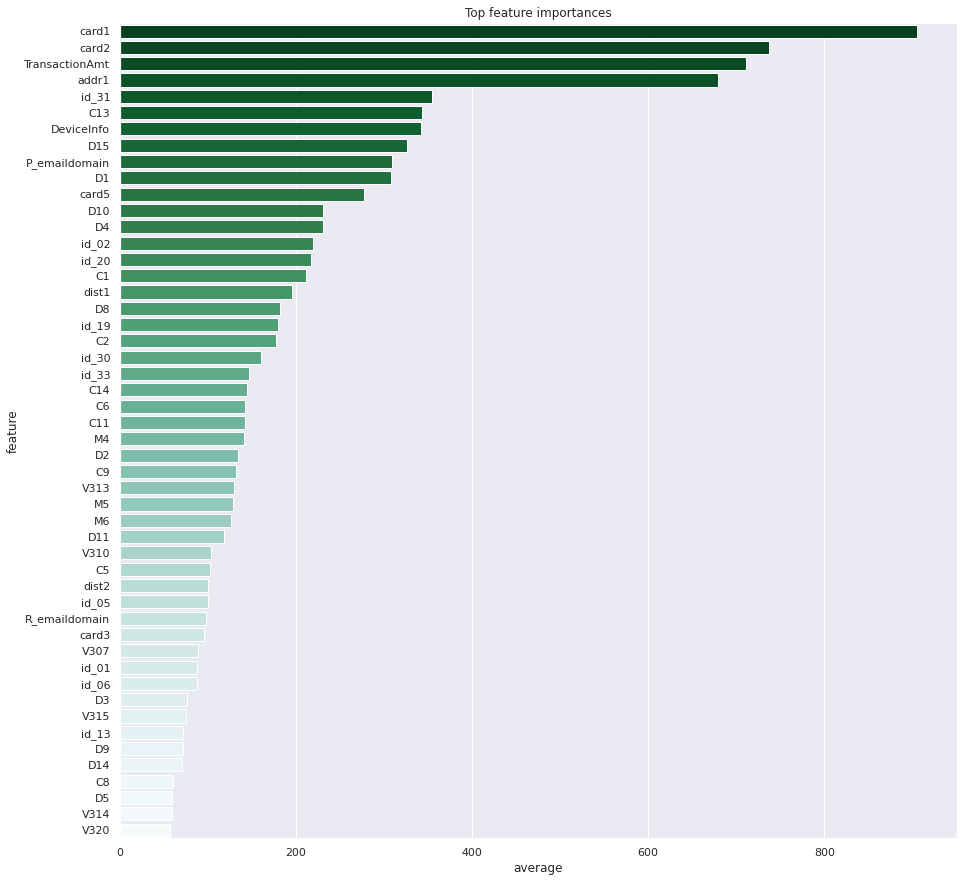

In [ ]:
plt.figure(figsize=(15, 15))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

Для получения итогового предсказания на тестовой выборке усредним предсказания моделей с разных фолдов.

In [ ]:
np.array(test_preds).shape

(4, 172981)

In [ ]:
final_pred = np.average(test_preds, axis=0)
final_pred

array([0.06674811, 0.05404055, 0.21179866, ..., 0.02268264, 0.02132404,
       0.04760948])

In [ ]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred})
sub.head()

,TransactionID,isFraud
0,3404559,0.066748
1,3404560,0.054041
2,3404561,0.211799
3,3404562,0.315280
4,3404563,0.382806


In [ ]:
sub.tail()

,TransactionID,isFraud
172976,3577535,0.020500
172977,3577536,0.046832
172978,3577537,0.022683
172979,3577538,0.021324
172980,3577539,0.047609


Сохраняем файл с предсказаниями - теперь его можно отправить в соревнование и посмотреть результат на публичной части.

In [ ]:
sub.to_csv('submission_baseline.csv', index=False)

Наконец, построим распределение предсказаний для целевой переменной на тестовой выборке.

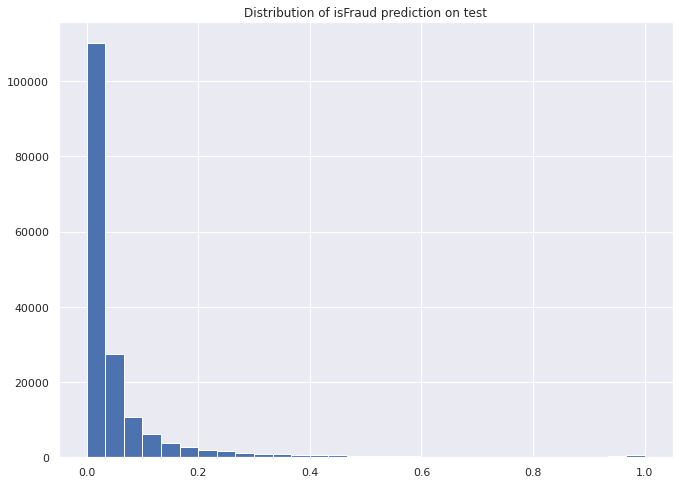

In [ ]:
plt.figure(figsize=(11, 8))
plt.hist(sub['isFraud'], bins=30)
plt.title('Distribution of isFraud prediction on test')
plt.show()